In [1]:
import re
import pandas as pd
# from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# import nltk
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

In [2]:
import tensorflow as tf

In [4]:
data = pd.read_csv('data_cleaning_lowercase_emoji_convert.csv')
data

,Comment,Label
0,jawa bang,1
1,tiupin kopi saya plis < EMOJI_GRIMACING_FACE >,0
2,mending meminta doa ke emak bapk kamu deh pada,0
3,coba jawa ini nganu atau muhammadiyah < EMOJI_...,1
4,laris manis jualan agama di djawa,1
...,...,...
6439,stereotype muncul bukan tanpa alasan dan stere...,1
6440,< EMOJI_FACE_WITH_TEARS_OF_JOY > sekarang vira...,0
6441,bangkalan madura < EMOJI_FACE_WITH_TEARS_OF_JOY >,1
6442,anaknya pak kadir banyak yang tidak beres nih ...,1


In [5]:
# Count the number of comments per label
label_counts = data["Label"].value_counts()

print("Jumlah komentar per label:")
print(label_counts)

Jumlah komentar per label:
Label
0    3412
1    3032
Name: count, dtype: int64


In [6]:
# Cek komentar yang kosong atau NaN
lost_comments = data[data['Comment'].isna() | (data['Comment'].str.strip() == "")]

print("Jumlah komentar hilang:", len(lost_comments))
print(lost_comments)

Jumlah komentar hilang: 2
     Comment  Label
740      NaN      0
3099     NaN      1


In [7]:
data = data[~(data['Comment'].isna() | (data['Comment'].str.strip() == ""))]
data

,Comment,Label
0,jawa bang,1
1,tiupin kopi saya plis < EMOJI_GRIMACING_FACE >,0
2,mending meminta doa ke emak bapk kamu deh pada,0
3,coba jawa ini nganu atau muhammadiyah < EMOJI_...,1
4,laris manis jualan agama di djawa,1
...,...,...
6439,stereotype muncul bukan tanpa alasan dan stere...,1
6440,< EMOJI_FACE_WITH_TEARS_OF_JOY > sekarang vira...,0
6441,bangkalan madura < EMOJI_FACE_WITH_TEARS_OF_JOY >,1
6442,anaknya pak kadir banyak yang tidak beres nih ...,1


In [8]:
comments = data['Comment'].tolist()
labels = data['Label'].values

In [9]:
vocab_size = 10000
max_length = 20
trunc_type = 'post'
oov_tok = "<OOV>"

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(comments)

# Menghitung jumlah kata unik
jumlah_kata = len(tokenizer.word_index)
print("Jumlah kata unik:", jumlah_kata)

Jumlah kata unik: 6260


In [11]:
lengths = [len(c.split()) for c in comments]
import numpy as np
print("Rata-rata panjang:", np.mean(lengths))
print("Maksimal panjang:", np.max(lengths))
print("Persentil 95:", np.percentile(lengths, 95))

Rata-rata panjang: 8.08196212356411
Maksimal panjang: 73
Persentil 95: 18.0


In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)
padded_sequences = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)


X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [13]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
# pip install scikeras

In [14]:
import gensim

# Load FastText pre-trained model (bahasa Indonesia, misal cc.id.300.bin)
fasttext = gensim.models.fasttext.load_facebook_model("../../../cc.id.300.bin")
embedding_dim = fasttext.vector_size  # biasanya 300

In [15]:
fasttext_wv = fasttext.wv

In [16]:
embedding_dim = fasttext_wv.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in fasttext_wv.key_to_index:
        embedding_matrix[i] = fasttext_wv[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [17]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

# === 1. Attention Layer ===
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)
    
    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = a * x
        return output  # tetap 3D untuk Conv1D

In [18]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Bidirectional, LSTM, Conv1D,
    BatchNormalization, GlobalMaxPooling1D,
    Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def build_model(hp):
    batch_size = hp.Choice("batch_size", [32, 64, 128])
    model = Sequential()

    # ---- Embedding ----
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        # input_length=max_length,
        weights=[embedding_matrix],
        trainable=False
    ))

    # ---- BiLSTM ----
    lstm_units = hp.Choice("lstm_units", [32, 64, 128, 256])
    model.add(Bidirectional(
        LSTM(
            lstm_units,
            return_sequences=True,
            dropout=0.4
        )
    ))

    # ---- Attention ----
    model.add(Attention())

    # ---- Convolution ----
    filters = hp.Choice("filters", [32, 64, 128, 256])
    model.add(Conv1D(filters=filters, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())

    # ---- Dense ----
    # dense_units = hp.Choice("dense_units", [32, 64, 128])
    model.add(Dense(64, activation="relu"))

    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dropout_rate))

    model.add(Dense(2, activation="softmax"))

    # ---- Optimizer ----
    lr = hp.Choice("learning_rate", [0.001])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [19]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=100,          # kamu mau 100? bisa diganti max_trials=100
    executions_per_trial=1,
    directory="tuner_bilstm_lowercase_with_emoji",
    project_name="randomsearch_instagram"
)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

tuner.search(
    X_train, y_train,
    epochs=10,
    batch_size=None,     # boleh fixed, atau kamu jadikan hyperparameter
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Trial 100 Complete [00h 00m 21s]
val_accuracy: 0.8828549385070801

Best val_accuracy So Far: 0.8859581351280212
Total elapsed time: 00h 49m 04s


In [21]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
# accuracy=gs.best_score_
best_model = tuner.get_best_models(num_models=1)[0]
# result = gs.cv_results_

C:\Users\fasilkom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [22]:
print(best_hp.values)
# print(accuracy)
print(best_model)

{'batch_size': 32, 'lstm_units': 64, 'filters': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001}
<Sequential name=sequential, built=True>


In [23]:
best_model.summary()

from tensorflow.keras.utils import plot_model
plot_model(best_model, to_file="best_model.png", show_shapes=True, show_layer_names=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 20, 128)        │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 20, 128)        │           148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 16, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,232,598 (12.33 MB)

 Trainable params: 232,470 (908.09 KB)

 Non-trainable params: 3,000,128 (11.44 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [24]:
# fin_model = best_model.model_

loss, accuracy = best_model.evaluate(X_val, y_val)
# .model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8860 - loss: 0.3290
Validation Loss: 0.3289760947227478, Validation Accuracy: 0.8859581351280212


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score


y_pred = (best_model.predict(X_val) > 0.5).astype(int)

precision = precision_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

accuracy = accuracy_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Accuracy: 0.8860
Precision: 0.8861
Recall: 0.8857
F1-Score: 0.8858


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


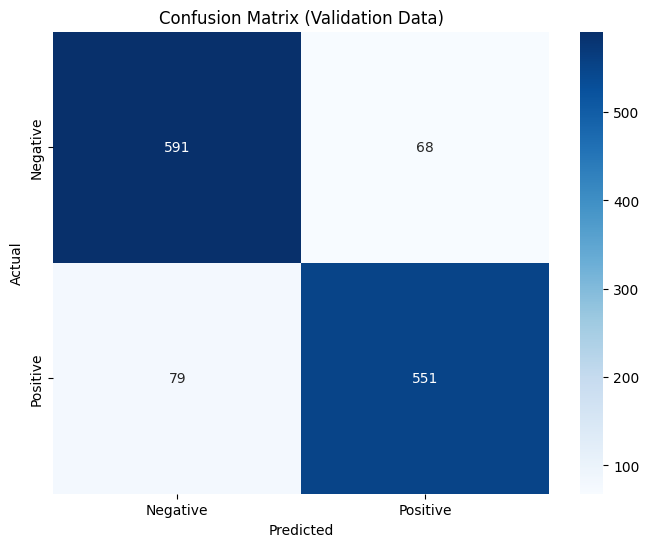

Classification Report (Validation Data):
              precision    recall  f1-score   support

    Negative       0.88      0.90      0.89       659
    Positive       0.89      0.87      0.88       630

    accuracy                           0.89      1289
   macro avg       0.89      0.89      0.89      1289
weighted avg       0.89      0.89      0.89      1289



In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


if len(y_val.shape) > 1 and y_val.shape[1] > 1:  
    y_val = np.argmax(y_val, axis=1)


y_pred_prob = best_model.predict(X_val)  
y_pred = np.argmax(y_pred_prob, axis=1)  


cm = confusion_matrix(y_val, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation Data)")
plt.show()


print("Classification Report (Validation Data):")
print(classification_report(y_val, y_pred, target_names=["Negative", "Positive"]))


In [ ]:
import numpy as np

# Untuk y_train
unique, counts = np.unique(y_train, return_counts=True)
print("Distribusi y_train:", dict(zip(unique, counts)))

# Untuk y_val
unique, counts = np.unique(y_val, return_counts=True)
print("Distribusi y_val:", dict(zip(unique, counts)))

In [27]:
best_model.save('model_random_search_lowercase_emoji_convert_8020.h5')

#TESTING

In [28]:
import numpy as np
from keras.models import load_model
# from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


model = load_model(
    'model_random_search_lowercase_emoji_convert_8020.h5',
    custom_objects={"Attention": Attention()}
)

In [29]:
df = pd.read_csv("../../../singkatan-lib.csv")

# ubah jadi dictionary {singkatan: normalisasi}
mapping = dict(zip(df['singkatan'], df['normalisasi']))
print(mapping)

{'aja': 'saja', 'akn': 'akan', 'aku': 'saya', 'amien': 'aamiin', 'amin': 'aamiin', 'and': 'dan', 'anda': 'kamu', 'ane': 'saya', 'ap': 'apa', 'aps': 'apa', 'aq': 'saya', 'bag': 'bagian', 'banget': 'sangat', 'beud': 'sangat', 'bgmn': 'bagaimana', 'bgt': 'sangat', 'bkan': 'bukan', 'bl': 'bila', 'blg': 'bilang', 'blh': 'boleh', 'blm': 'belum', 'blom': 'belum', 'blum': 'belum', 'bpk': 'bapak', 'bs': 'bisa', 'bsa': 'bisa', 'bsk': 'besok', 'cb': 'coba', 'cm': 'hanya', 'cma': 'hanya', 'cuma': 'hanya', 'd': 'di', 'dg': 'dengan', 'dgn': 'dengan', 'dlm': 'dalam', 'dn': 'dan', 'dng': 'dengan', 'dpt': 'dapat', 'dr': 'dari', 'drpd': 'daripada', 'dsar': 'dasar', 'dy': 'dia', 'dya': 'dia', 'en': 'dan', 'enggak': 'tidak', 'ente': 'kamu', 'g': 'tidak', 'ga': 'tidak', 'gak': 'tidak', 'gitu': 'begitu', 'gk': 'tidak', 'gt': 'begitu', 'gtau': 'tidak tahu', 'gua': 'saya', 'gub': 'gubernur', 'gue': 'saya', 'gw': 'saya', 'hny': 'hanya', 'hrs': 'harus', 'hrus': 'harus', 'insaallah': 'insyaa allah', 'insallah': 

In [30]:
dt = pd.read_csv("../../../kamus_alay.csv")

# ubah jadi dictionary {singkatan: normalisasi}
mapping_slang = dict(zip(dt['slang'], dt['normalisasi']))
print(mapping_slang)

{'woww': 'wow', 'aminn': 'amin', 'met': 'selamat', 'netaas': 'menetas', 'keberpa': 'keberapa', 'eeeehhhh': 'eh', 'kata2nyaaa': 'kata-katanya', 'hallo': 'halo', 'kaka': 'kakak', 'ka': 'kak', 'daah': 'dah', 'aaaaahhhh': 'ah', 'yaa': 'ya', 'smga': 'semoga', 'slalu': 'selalu', 'amiin': 'amin', 'kk': 'kakak', 'trus': 'terus', 'sii': 'sih', 'nyenengin': 'menyenangkan', 'bgt': 'banget', 'gemess': 'gemas', 'akuuu': 'aku', 'jgn': 'jangan', 'udah': 'sudah', 'gitu': 'begitu', 'aja': 'saja', 'gemesiin': 'menggemaskan', 'menyenangkn': 'menyenangkan', 'rb': 'ribu', 'akau': 'aku', 'saranin': 'menyarankan', 'nemuin': 'menemukan', 'yah': 'ya', 'mnis2nya': 'manis-manisnya', 'gtu': 'begitu', 'tu': 'itu', 'idolaa': 'idola', 'bangett': 'banget', 'kaakk': 'kak', 'baaiikkk': 'baik', 'telaatt': 'telat', 'kaak': 'kak', 'yg': 'yang', 'lg': 'lagi', 'skarang': 'sekarang', 'sempet': 'sempat', 'karna': 'karena', 'ngga': 'enggak', 'mantep': 'mantap', 'loohhh': 'loh', 'yeee': 'ya', 'baguuuuus': 'bagus', 'sampe': 'sam

In [31]:
mapping_tambahan = {
    "jowo" : "jawa",
    "meduro" : "madura",
    "meksiko" : "mexico",
    "vindavana" : "vrindavan",
    "frindavan" : "vrindavan",
    "frindapan" : "vrindavan",
    "prindavan"  : "vrindavan",
    "frindafan" : "vrindavan",
    "prindapan"  : "vrindavan",
    "vrindapan" : "vrindavan",
    "vrindafan" : "vrindavan",
}

In [32]:
import re

def normalize_laughter(token):
    # cocokkan pola 'wk' atau variasi 'wkwkwkwk' / 'wkkwkwkw'
    if re.fullmatch(r'(w|k){3,}', token):  # hanya huruf w dan k dengan panjang >3
        return 'wkwk'
    elif re.fullmatch(r'(ha){2,}', token):  # untuk 'hahaha', 'hahahah'
        return 'haha'
    return token

In [34]:
pip install indonlp

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\fasilkom\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [35]:
import re
import pandas as pd
# from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
import pandas as pd
from indoNLP.preprocessing import replace_word_elongation
from indoNLP.preprocessing import emoji_to_words, replace_slang

In [36]:
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fasilkom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fasilkom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\fasilkom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fasilkom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [37]:
# Initialize lemmatizer and stemmer
stopword = StopWordRemoverFactory()
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

In [39]:
pip install emoji

   ---------------------------------------- 0.0/608.4 kB ? eta -:--:--
   ---------------------------------------- 608.4/608.4 kB 10.8 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\fasilkom\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [40]:
import emoji

In [41]:
def textcleaning(text, oov_token="<OOV>"):       
    # hapus mention @username
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'([a-zA-Z0-9])([\U0001F600-\U0001F64F'
                  r'\U0001F300-\U0001F5FF'
                  r'\U0001F680-\U0001F6FF'
                  r'\U0001F1E0-\U0001F1FF])', r'\1 \2', text)
    text = re.sub(r'[^a-zA-Z\s' 
                  r'\U0001F600-\U0001F64F'  # emotikon wajah
                  r'\U0001F300-\U0001F5FF'  # simbol & pictograph
                  r'\U0001F680-\U0001F6FF' 
                  r'\U0001F1E0-\U0001F1FF'
                  r']+', ' ', text, flags=re.UNICODE)
    
    text = re.sub(r'\s+', ' ', text).strip()          # hapus spasi ganda
    text = text.strip()  # Remove leading/trailing whitespace
    # 1. Remove special characters, numbers, and extra spaces
    # text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special charactersx

    text = text.lower()  # Convert to lowercase

    
    text = re.sub(r'(.)\1{2,}', r'\1', text)          # huruf berulang >2 jadi 1
    text = replace_word_elongation(text)  
     
    text = emoji.replace_emoji(
            text,
            replace=lambda e, data: f" <EMOJI_{emoji.demojize(e).strip(':').upper()}> "
        )
    text = replace_slang (text)

    tokens = nltk.word_tokenize(text)


    tokens = [mapping_tambahan.get(word, word) for word in tokens]

    tokens = [normalize_laughter(t) for t in tokens]

    tokens = [mapping.get(word, word) for word in tokens]
    tokens = [mapping_slang.get(word, word) for word in tokens]

    # tokens = [stemmer.stem(word) for word in tokens]
    
    text = ' '.join(tokens)
    return text

In [42]:
texts_to_predict = [
    "jawa hama😂",
    "Duh kok bisa ya kayak gitu",
    "Meduroooo kebiasaan",
    "meresahkan wkwk😂😂",
    "😂😂",
    "Tiupin kopi saya plis 😬"
]

cleaned_texts = [textcleaning(text) for text in texts_to_predict]

sequences = tokenizer.texts_to_sequences(cleaned_texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, truncating='post')

predictions = model.predict(padded_sequences)

predicted_labels = np.argmax(predictions, axis=1)

for i, text in enumerate(cleaned_texts):
    print(f"Cleaned Text: {cleaned_texts[i]}")
    print(f"Predicted Label: {predicted_labels[i]}")
    print(f"Prediction Probabilities: {predictions[i]}")
    print('')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
Cleaned Text: jawa hama < EMOJI_FACE_WITH_TEARS_OF_JOY >
Predicted Label: 1
Prediction Probabilities: [0.00174474 0.9982552 ]

Cleaned Text: duh kok bisa ya seperti begitu
Predicted Label: 0
Prediction Probabilities: [0.9505464  0.04945356]

Cleaned Text: madura kebiasaan
Predicted Label: 1
Prediction Probabilities: [0.00445653 0.99554354]

Cleaned Text: meresahkan wkwk < EMOJI_FACE_WITH_TEARS_OF_JOY > < EMOJI_FACE_WITH_TEARS_OF_JOY >
Predicted Label: 0
Prediction Probabilities: [0.7726158  0.22738425]

Cleaned Text: < EMOJI_FACE_WITH_TEARS_OF_JOY > < EMOJI_FACE_WITH_TEARS_OF_JOY >
Predicted Label: 0
Prediction Probabilities: [0.6581265  0.34187347]

Cleaned Text: tiupin kopi saya plis < EMOJI_GRIMACING_FACE >
Predicted Label: 0
Prediction Probabilities: [9.9998641e-01 1.3603892e-05]



In [ ]:
# import scikeras
# print(scikeras.__version__)
